1.Import the 'hot_songs.csv' file created in 'Webscraping.ipynb'
2.Get song features from Spotify API
3.Create clustering model based on dataset from 'https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks'
4.Create the prototype for the song-recommender: If the song input is in the 'hot songs' dataset, the app will recommend another song in the same dataset, if not the app will get the feature of the song input by using Spotify API, then return another song in the same cluster in Kaggle dataset.

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Get the Hot_Song 


In [ ]:
hot_song = pd.read_csv('/content/drive/MyDrive/hot_song.csv')

In [ ]:
hot_song

,song,artist,year
0,Drivers License,Olivia Rodrigo,2021
1,34+35,Ariana Grande,2021
2,Calling My Phone,Lil Tjay Featuring 6LACK,2021
3,Blinding Lights,The Weeknd,2021
4,Up,Cardi B,2021
...,...,...,...
195,Germaphobe,Hockey Dad,2020
196,Audacity,Stormzy featuring Headie One,2020
197,Your Man,Joji,2020
198,Itch,Hockey Dad,2020


## Get data from Spotify

###Loading credentials from another config file

In [ ]:
import sys
sys.path.insert(1, '/content/drive/MyDrive')
from config_spotify import *

###Staring with SportifyAPI

In [ ]:
!pip install spotipy
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials


#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= ClientID,
                                                           client_secret= ClientSecret))

# The "sp" variable has two useful funtions:
# The first usefull function is:
# .search(q='',limit=n)
# Where the "q" keyword is the query you want to perform on spotify: song_name, artist,...
# while The "limit" keyword will limit the number of returned results.
#
# The second usefull function is:
# .audio_features([URL|URI|ID])
# which returns some 'features of the song', that after cleanup, we can use in order to characterize a song.


In [ ]:
# change format of df_final['song'] to fit the format of spotifyAPI
title_lower = map(lambda x:x.lower(),hot_song['song'])
songlist = list(title_lower)
songlist

['drivers license',
 '34+35',
 'calling my phone',
 'blinding lights',
 'up',
 'save your tears',
 'mood',
 'go crazy',
 'levitating',
 'positions',
 "love story (taylor's version)",
 'what you know bout love',
 'therefore i am',
 'for the night',
 'whoopty',
 'back in blood',
 'holy',
 'good days',
 'i hope',
 'better together',
 'dakiti',
 'lonely',
 'you broke me first.',
 "you're mines still",
 'willow',
 'body',
 'streets',
 'anyone',
 "my ex's best friend",
 'throat baby (go baby)',
 'bang!',
 'on me',
 'before you go',
 'lemonade',
 'good time',
 'laugh now cry later',
 'starting over',
 'best friend',
 'put your records on',
 'just the way',
 'cry baby',
 'beers and sunshine',
 'without you',
 'damage',
 'dynamite',
 'down to one',
 'buss it',
 'long live',
 "we're good",
 'time today',
 'what it feels like',
 'hole in the bottle',
 'wasted on you',
 'beat box',
 'the good ones',
 "what's your country song",
 'sand in my boots',
 'golden',
 'monsters',
 'goosebumps',
 'my head 

search for a song from Spotify to understand what features information included

In [ ]:
skin = sp.search(q='skin', limit=1) 
#len(skin["tracks"]["items"])
#skin["tracks"]["items"][0].keys()
skin["tracks"]["items"][0]["uri"]
#my_dict = sp.audio_features(skin["tracks"]["items"][0]["uri"]) # my_dict is a list with a dictionary
my_dict = sp.audio_features(skin["tracks"]["items"][0]["uri"])[0] # my_dict is now a dictionary

#my_dict
# Change it to a pandas dataframe
my_dict_new = { key:[my_dict[key]] for key in list(my_dict.keys()) }
spotify_features = pd.DataFrame(my_dict_new)
spotify_features.select_dtypes(np.number)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.557,0.457,7,-5.372,1,0.0335,0.428,0,0.0567,0.328,105.918,177500,4


##Create K-means model

### Get DataSet from Kaggle.com

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Spotify_project/data.csv')


In [ ]:
data.head()


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [ ]:
data.shape

(174389, 19)

In [ ]:
#drop na
data=data.dropna()
data.shape

(174389, 19)

In [ ]:
#keep only features that match the Spotify features and rearrange the order:
df = data[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms']]

My decision is to keep these features:'acousticness','danceability','duration_ms','energy','instrumentalness','liveness','popularity','tempo','year' to do clustering

### Function to preprocess the features

In [ ]:
from bs4 import BeautifulSoup
import requests
from datetime import date
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [ ]:
df_numeric = df.select_dtypes(np.number)
df_numeric
#danceability	energy	key	loudness	mode	speechiness	acousticness	instrumentalness	liveness	valence	tempo	duration_ms	time_signature

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.598,0.224,5,-12.628,0,0.0936,0.991000,0.000522,0.3790,0.6340,149.976,168333
1,0.852,0.517,5,-7.261,0,0.0534,0.643000,0.026400,0.0809,0.9500,86.889,150200
2,0.647,0.186,0,-12.098,1,0.1740,0.993000,0.000018,0.5190,0.6890,97.600,163827
3,0.730,0.798,2,-7.311,1,0.0425,0.000173,0.801000,0.1280,0.0422,127.997,422087
4,0.704,0.707,10,-6.036,0,0.0768,0.295000,0.000246,0.4020,0.2990,122.076,165224
...,...,...,...,...,...,...,...,...,...,...,...,...
174384,0.792,0.866,6,-5.089,0,0.0356,0.009170,0.000060,0.1780,0.1860,125.972,147615
174385,0.429,0.211,4,-11.665,1,0.0360,0.795000,0.000000,0.1960,0.2280,94.710,144720
174386,0.671,0.589,4,-12.393,0,0.0282,0.806000,0.920000,0.1130,0.7140,108.058,218147
174387,0.462,0.240,0,-12.077,1,0.0377,0.920000,0.000000,0.1130,0.3200,171.319,244000


In [ ]:
#define a function for scaling
def scaling(df):
   scaler = StandardScaler().fit(df)
   X_prep = scaler.transform(df)
   return scaler, X_prep

In [ ]:
# call the function
scaler, X_prep=scaling(df_numeric)

In [ ]:
X_prep

array([[ 0.34791933, -0.94879121, -0.05835388, ...,  0.41390256,
         1.08975345, -0.4344949 ],
       [ 1.79089823,  0.12570987, -0.05835388, ...,  1.60871779,
        -0.99548519, -0.55668873],
       [ 0.62628927, -1.08814629, -1.47950215, ...,  0.62186091,
        -0.64145043, -0.46485973],
       ...,
       [ 0.76263374,  0.38975108, -0.34258353, ...,  0.71638743,
        -0.29577817, -0.09881057],
       [-0.4246993 , -0.89011538, -1.47950215, ..., -0.77335055,
         1.79521175,  0.07540645],
       [ 0.79671985, -0.08332277,  0.51010543, ...,  0.84116244,
        -0.15860664, -0.2365305 ]])

### Checking the inertia

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

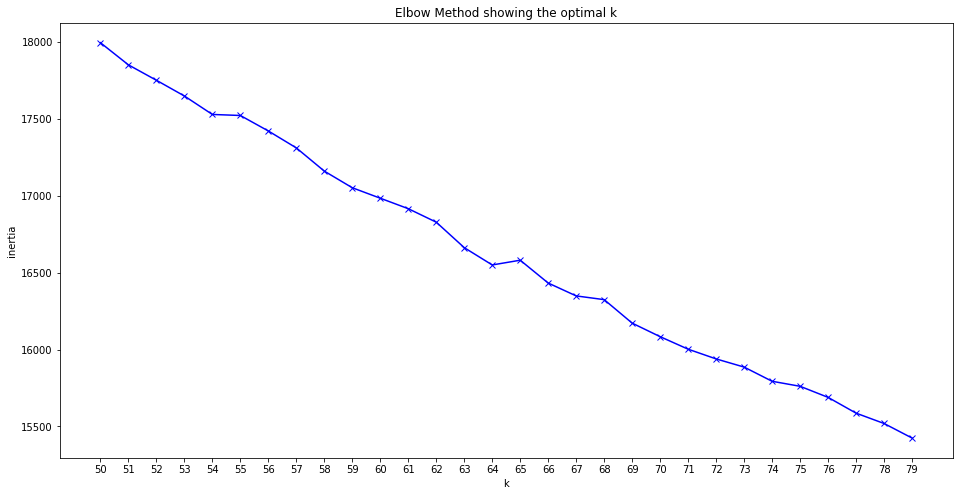

In [ ]:
K = range(50, 80)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

We can not decided on any elbow point from the graph

### Checking the Silhouette score

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

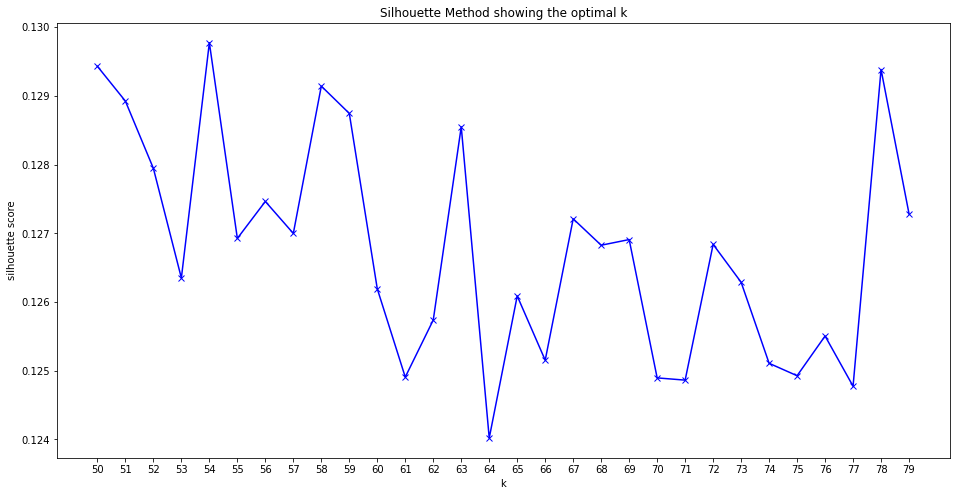

In [ ]:
K = range(50, 80)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

The high point is where k = 55, therefore I'll choose 55 as my n_clusters


In [ ]:
km = KMeans(n_clusters=55)
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=55, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
y_predict = km.fit(X_prep)
y_predict

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=55, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
clusters = km.predict(X_prep)

In [ ]:
X_df = data.copy()
X_df['cluster'] = clusters
X_df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,cluster
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920,19
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920,29
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920,23
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920,31
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920,30


In [ ]:
data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,cluster
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920,19
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920,29
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920,23
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920,31
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920,30


Include the cluster in our dataset

In [ ]:
X_df.to_csv('/content/drive/MyDrive/Spotify_project/cluster.csv', index=False)

## Create a prototype

In [ ]:
#installing fuzzywuzzy for correcting misspelling
#pip install fuzzywuzzy
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import random
from random import randint

In [ ]:
def prototype(scaler,km):
    song = str(input ("Enter your favourtie song:"))
    if song in hot_song['song'].tolist():
      print("The song",song,"is a Hot Song!, therefore you should also like ", str(random.choice(hot_song['song'])), "as it was also popular that week")
    else:
      # look for the song in Spotify
      features = sp.search(q=song, limit=1) 
      my_dict = sp.audio_features(features["tracks"]["items"][0]["uri"])[0] #get the Spotify features of the song
      my_dict_new = { key:[my_dict[key]] for key in list(my_dict.keys()) }
      input_song = pd.DataFrame(my_dict_new)# get the dataframe of features
      input_song = input_song.drop('time_signature',axis=1) #feature'time_signature' is not in our dataset
      input_song = input_song.select_dtypes(np.number) #prepocess the input
      song_scaled = scaler.transform(input_song) #scaling the features
      song_cluster = km.predict(song_scaled)[0]
      print('You favorite song is',song)
      print('Therefore,I have a recommendation for you! ', random.choice( data[data['cluster'] == int(song_cluster)]['name'].values ))







In [ ]:
prototype(scaler,km)

Enter your favourtie song:Wonderball
You favorite song is Wonderball
Therefore,I have a recommendation for you!  Dizzy Miss Lizzy - Live; 2008 Remaster


# Actions for improvement

In [ ]:
#try to deal with the input typo
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from random import randint
def search_song(song_choice=input("Please choose song: ")):
    request = song_choice
    list_songs = [song for song in hot_song['song']]
    x = process.extractOne(request, list_songs, scorer=fuzz.token_sort_ratio)
    print("Did you mean this song? " + str(x[0]))
    correct = input("Please, choose yes or no: ")
    if correct.lower != 'no':
        x = hot_song.sample().values.flatten().tolist()
        return "Well, I think you might like this tune: {0} by {1}".format(str(x[0]), str(x[1]))
    else:
        return "Apologies, listen to some proper music and I can help!"
search_song('skinskiesg')



Please choose song: skinskiesg
Did you mean this song? Skin
Please, choose yes or no: no


'Well, I think you might like this tune: The Good Ones by Gabby Barrett'